## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve
import dataclasses as dc
import tempfile

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
import yaml
from mlflow.tracking import MlflowClient
from matplotlib.font_manager import FontProperties
import matplotlib
import sklearn.preprocessing as preprocessing
from omegaconf import OmegaConf
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchviz import make_dot
from torchinfo import summary

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))
import src.model.network as network
import src.model.train as train
import src.dataset.time_dataset as time_dataset

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

In [7]:
# gpu
torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# chdir
current_dir=pathlib.Path().resolve()
if current_dir.stem=="notebooks":
    os.chdir(current_dir.parent)
logger.info(pathlib.Path().resolve())

INFO:__main__:/workspaces/load_to_goal/GitHub/pytorch-implementation/time_series_forecasting


## load data&model

In [9]:
# mlflow global parameter
experiment_name="model01"
run_id="70e2c35c428d4892bdf25778473b5dd8"
tracking_uri="logs/mlruns"

In [10]:
def load_config():
    client = MlflowClient(tracking_uri=tracking_uri)
    with tempfile.TemporaryDirectory() as dname:
        config_path=client.download_artifacts(run_id,"config.yaml",dname)
        with open(config_path) as f:
            config=yaml.load(f,Loader=yaml.SafeLoader)
        config = OmegaConf.create(config)
    return config

In [11]:
def load_data_model(config):
    client = MlflowClient(tracking_uri=tracking_uri)
    with tempfile.TemporaryDirectory() as dname:
        # data
        df_train=pd.read_csv(config.data_path).iloc[:,1:]
        df_train=df_train[5::6]
        val_length=int(len(df_train)*config.val_ratio)
        array_val=df_train.iloc[-val_length:].values
        array_train=df_train.iloc[:-val_length].values
        scaler = preprocessing.StandardScaler().fit(array_train)
        array_train = scaler.transform(array_train)
        array_val = scaler.transform(array_val) 
        
        # model
        model_path=[artifact.path for artifact 
                    in client.list_artifacts(run_id)
                    if "pth" in artifact.path][0]
        model_path=client.download_artifacts(run_id,model_path,dname)
        net=network.LSTM(
            input_size=array_train.shape[1],
            hidden_size=config.hidden_size,
            output_size=array_train.shape[1]*config.label_length,
        )
        model = train.TimeSeriesForecast(
            model=net,
            **config,
        )
        model.load_state_dict(torch.load(model_path))
        model=model.to(device)
        model.eval()
        
    return array_train,model

In [12]:
config=load_config()

In [13]:
array_train,model=load_data_model(config)

In [14]:
td=time_dataset.TimeDataset(array_train,config.input_length,config.label_length)

## inference

In [15]:
input=td[0][0].unsqueeze(0).to(device)
label=td[0][1].numpy()
output=model(input).view(input.shape).to("cpu").detach().numpy()

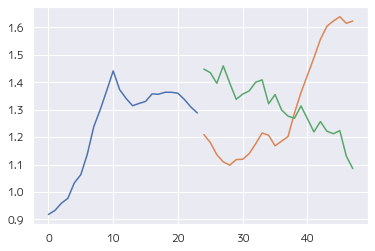

In [16]:
plt.plot(list(range(config.input_length)),input.to("cpu").detach().numpy()[0,:,0])
plt.plot(list(range(config.input_length,config.input_length+config.label_length)),label[:,0])
plt.plot(list(range(config.input_length,config.input_length+config.label_length)),output[0,:,0])

## ネットワーク構造の可視化

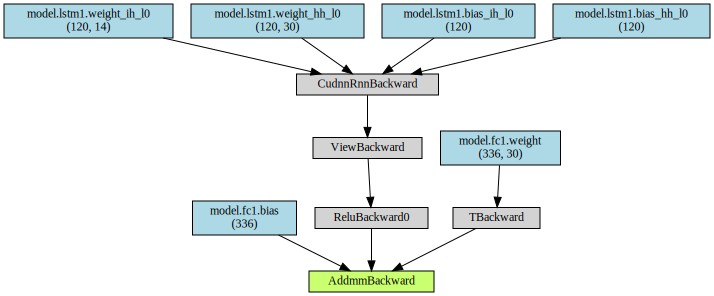

In [17]:
output=model(input)
make_dot(output,params=dict(model.named_parameters()))

/workspaces/load_to_goal/GitHub/pytorch-implementation/.venv/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:1801: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


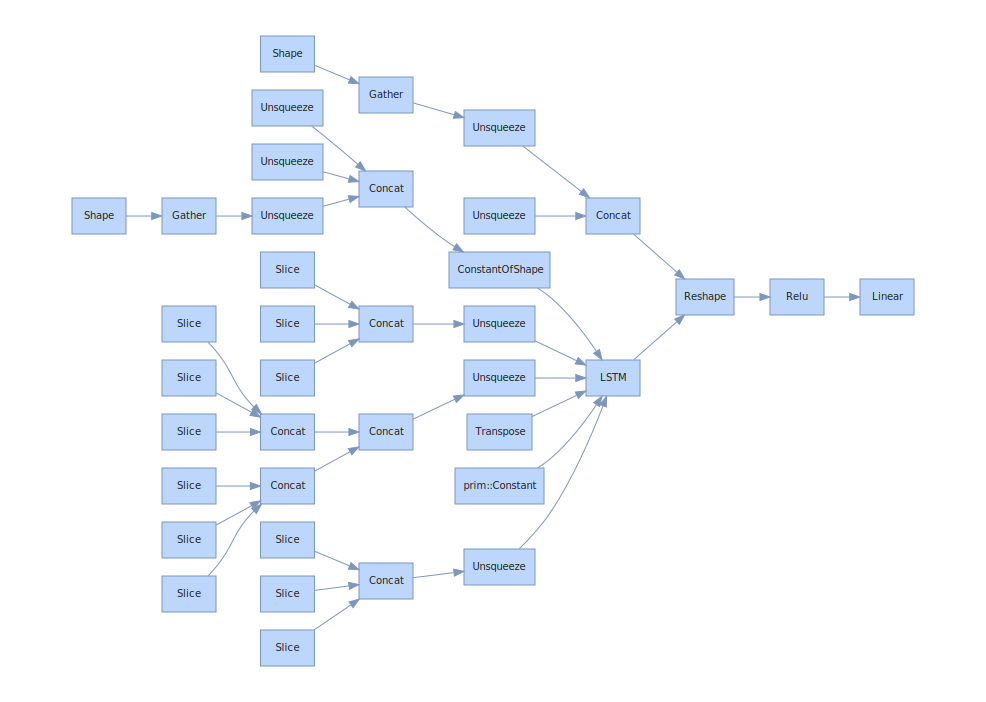

In [18]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(model, input, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph

In [19]:
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(model, input, './notebooks/rnn.onnx', input_names=input_names, output_names=output_names)

/workspaces/load_to_goal/GitHub/pytorch-implementation/.venv/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:1801: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


In [20]:
summary(
    model,
    input_data=input.shape,
    col_names=["output_size", "num_params"]
    )

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [1, 336]                  --
|    └─LSTM: 2-1                         [1, 24, 30]               5,520
|    └─Linear: 2-2                       [1, 336]                  10,416
Total params: 15,936
Trainable params: 15,936
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [1, 336]                  --
|    └─LSTM: 2-1                         [1, 24, 30]               5,520
|    └─Linear: 2-2                       [1, 336]                  10,416
Total params: 15,936
Trainable params: 15,936
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.07